In [2]:
import numpy as np
from acv_explainers import ACXplainer
from acv_explainers.utils import *
from sklearn.linear_model import LogisticRegression
from utils import DatasetHelper, DATASETS_NAME
from sklearn.metrics import roc_auc_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [5]:
results = load_model('/home/xxxxxx/cet_rei2/BREASTCANCERCR_results')

In [6]:
def get_sr_results(x_test, rules, x_rules, y_rules, s_star, predict):
    N = rules.shape[0]
    d = rules.shape[1]
    
    coverages = []
    accuracies = []
    supports = []
    for idx in tqdm(range(N)):
        x_in = np.prod([(x_test[:, s] <= rules[idx, s, 1]) * (x_test[:, s] > rules[idx, s, 0])
                        for s in range(d)], axis=0).astype(bool)
        
        if  np.sum(x_in) == 0:
            continue
            
        coverage = np.mean(x_in)
        accuracy = np.mean(predict(x_test[x_in]) == y_rules[idx].reshape(1, -1))
        
        coverages.append(coverage)
        accuracies.append(accuracy)
        supports.append(len(s_star[idx]))
        
    return coverages, accuracies, supports, rules

In [7]:
coverages_sr, accuracies_sr, supports_sr, rules_sr = get_sr_results(results.x_test, results.rules, results.x_rules, results.y_rules,
                                                                        results.S_star_se, results.acv_explainer.predict)

100%|███████████████████████████████████████| 455/455 [00:00<00:00, 1077.50it/s]


In [8]:
N = results.rules.shape[0]
print('SR: Coverage = {} - Accuracy = {} - Support = {}'.format(np.sum(coverages_sr)/N, np.sum(accuracies_sr)/N, 
                                                            np.sum(supports_sr)/N))


SR: Coverage = 0.13815307499518026 - Accuracy = 0.8768716690375675 - Support = 2.221978021978022


In [9]:
print('SR STD: Coverage = {} - Accuracy = {} - Support = {}'.format(np.var(coverages_sr), np.var(accuracies_sr), 
                                                            np.var(supports_sr)))


SR STD: Coverage = 0.011366101685202077 - Accuracy = 0.0032360186519881226 - Support = 0.38920155969179293


In [10]:
from anchor import utils
from anchor import anchor_tabular

In [21]:
feature_names = ['meanradius',
 'meantexture',
 'meanperimeter',
 'meanarea',
 'meansmoothness',
 'meancompactness',
 'meanconcavity',
 'meanconcavepoints',
 'meansymmetry',
 'meanfractaldimension',
 'radiuserror',
 'textureerror',
 'perimetererror',
 'areaerror',
 'smoothnesserror',
 'compactnesserror',
 'concavityerror',
 'concavepointserror',
 'symmetryerror',
 'fractaldimensionerror',
 'worstradius',
 'worsttexture',
 'worstperimeter',
 'worstarea',
 'worstsmoothness',
 'worstcompactness',
 'worstconcavity',
 'worstconcavepoints',
 'worstsymmetry',
 'worstfractaldimension']

target_labels = ['True', 'False']

    
columns_names = feature_names
columns_id = {}
for i, col in enumerate(columns_names):
    columns_id[col] = i

In [22]:
explainer = anchor_tabular.AnchorTabularExplainer(
    target_labels,
    feature_names,
    results.x_train
    )

In [23]:
def get_anchor_results(explainer, x_test, x_train, predict, pi, columns_id):
    N = x_train.shape[0]
    d = x_train.shape[1]
    rules = np.ones(shape=(N, d, 2))
    rules[:, :, 0] = -1e+10
    rules[:, :, 1] = 1e+10
    
    coverages = []
    accuracies = []
    supports = []
    for idx in tqdm(range(N)):
        exp = explainer.explain_instance(x_train[idx], predict, threshold=pi)
        for r in exp.names():
            r_split = r.split()
            
            if len(r_split) == 3:
                col_id = columns_id[r_split[0]]
                if r_split[1] == '<' or r_split[1] == '<=':
                    rules[idx, col_id, 1] = r_split[2]
                elif r_split[1] == '>' or r_split[1] == '>=':
                    rules[idx, col_id, 0] = r_split[2]
                else:
                    raise ValueError
            elif len(r_split) == 5:
                col_id = columns_id[r_split[2]]
                rules[idx, col_id, 0] = r_split[0]
                rules[idx, col_id, 0] = r_split[-1]
            else:
                raise ValueError

        x_train_in = np.prod([(x_train[:, s] <= rules[idx, s, 1]) * (x_train[:, s] > rules[idx, s, 0])
                        for s in range(d)], axis=0).astype(bool)
        x_in = np.prod([(x_test[:, s] <= rules[idx, s, 1]) * (x_test[:, s] > rules[idx, s, 0])
                        for s in range(d)], axis=0).astype(bool)
        
        if np.sum(x_train_in) * np.sum(x_in) == 0:
            continue
            
#         if np.abs(np.mean(x_train_in)-exp.coverage())>0.01:
#             print(r)
#             print(np.mean(x_train_in), exp.coverage())
#             raise Warning('Inconsistency of the rules for this obs')
            
        
        coverage = np.mean(x_in)
        accuracy = np.mean(predict(x_test[x_in]) == predict(x_train[idx].reshape(1, -1)))
        
        coverages.append(coverage)
        accuracies.append(accuracy)
        supports.append(len(exp.names()))
        
    return coverages, accuracies, supports, rules

        

In [24]:
coverages, accuracies, supports, rules = get_anchor_results(explainer, results.x_test, results.x_rules, 
                                                            results.acv_explainer.predict, pi=0.9, columns_id=columns_id)

100%|█████████████████████████████████████████| 455/455 [27:22<00:00,  3.61s/it]


In [25]:
# N = x_test.shape[0]
# N = 500
print('ANCHORS: Coverage = {} - Accuracy = {} - Support = {}'.format(np.sum(coverages)/N, np.sum(accuracies)/N, 
                                                            np.sum(supports)/N))


ANCHORS: Coverage = 0.25022170811644495 - Accuracy = 0.982079389378976 - Support = 2.010989010989011


In [26]:
# N = x_test.shape[0]
# N = 500
print('ANCHORS STD: Coverage = {} - Accuracy = {} - Support = {}'.format(np.var(coverages), np.var(accuracies), 
                                                            np.var(supports)))


ANCHORS STD: Coverage = 0.011289816455719581 - Accuracy = 0.0012202572500791592 - Support = 0.027993962664883652


<AxesSubplot:ylabel='count'>

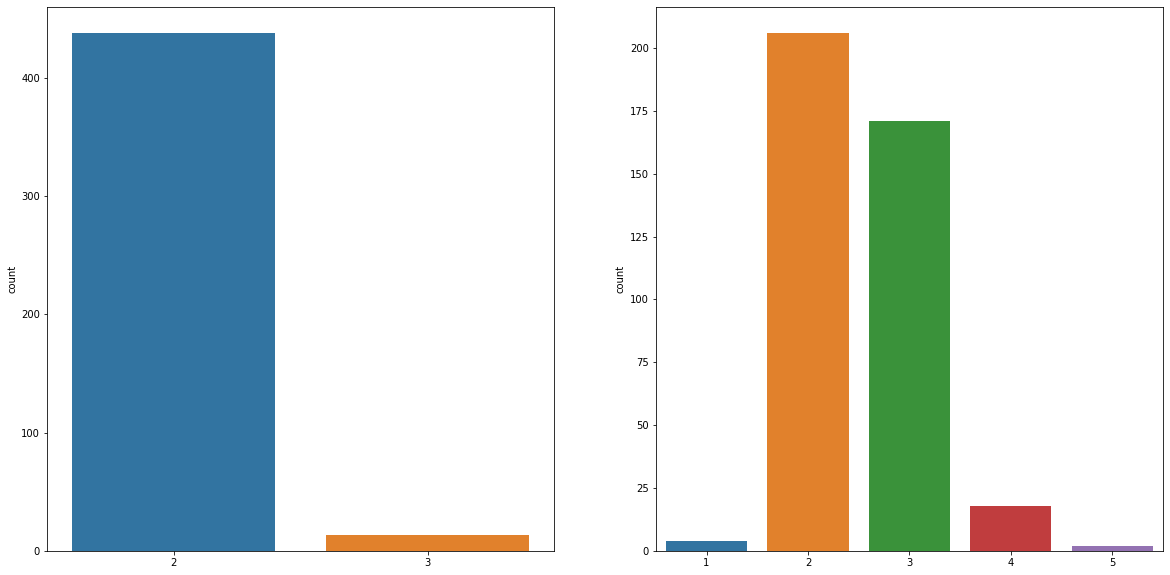

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.countplot(ax = ax[0], x=supports)
sns.countplot(ax = ax[1], x=supports_sr)

In [28]:
unique, count = np.unique(supports, return_counts=True)
unique_sr, count_sr = np.unique(supports_sr, return_counts=True)

In [29]:
count_support = dict(zip(unique, count))
count_support_sr = dict(zip(unique_sr, count_sr))

In [30]:
count_support

{2: 438, 3: 13}

In [32]:
count_support_sr

{1: 4, 2: 206, 3: 171, 4: 18, 5: 2}